## E/Gamma HLT efficiency from NanoAOD using Tag and Probe.

In this tutorial, we explain the basic usage of this package to perform efficiency measurements of single electron triggers using tag and probe.

To setup this package please follow the README in the package's [Github repository](https://github.com/iasonkrom/egamma-tnp). We will first showcase the usage using 2 root files locally and then showcase how the package is meant to be used on a cluster (like LPC or LXPLUS).

Let's start by importing some stuff and setting some plotting parameters. The important things here are `TagNProbe` and `plot_efficiency`. The rest are just for plotting customization.

In [1]:
import dask_awkward as dak  # This is not required. It's for showcasing purposes
import mplhep as hep
from egamma_tnp import TagNProbe
from egamma_tnp.plot import plot_efficiency
from matplotlib import pyplot as plt

hep.style.use("CMS")
hep.style.use({"font.size": 16})
hep.style.use({"figure.figsize": (6.4, 4.8)})

The main thing that we are gonna use is the `TagNProbe` object. Let's look at it's docstrings.

In [2]:
help(TagNProbe)

Help on class TagNProbe in module egamma_tnp.tnp:

class TagNProbe(builtins.object)
 |  TagNProbe(names, trigger_pt, *, goldenjson=None, toquery=False, redirect=False, custom_redirector='root://cmsxrootd.fnal.gov/', invalid=False)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, names, trigger_pt, *, goldenjson=None, toquery=False, redirect=False, custom_redirector='root://cmsxrootd.fnal.gov/', invalid=False)
 |      Tag and Probe for HLT Trigger efficiency from NanoAOD.
 |      
 |      Parameters
 |      ----------
 |          names : str or list of str
 |              The dataset names to query that can contain wildcards or a list of file paths.
 |          trigger_pt : int or float
 |              The Pt threshold of the trigger.
 |          goldenjson : str, optional
 |              The golden json to use for luminosity masking. The default is None.
 |          toquery : bool, optional
 |              Whether to query DAS for the dataset names. The default is False.
 |      

Let's therefore define such an object passing in a list of two local root files, a Pt threshold of 32 and a golden json file path. We must also set `toquery` and `redirect` to `False` because these files are local and we don't want to query `rucio` for those files nor change their `xrootd` redirector.

After that, we need to load those events using the `load_events()` method.

In [3]:
%%time

tag_n_probe = TagNProbe(
    ["../root_files/Egamma0.root", "../root_files/Egamma1.root"],
    32,
    goldenjson="../json/Cert_Collisions2023_366442_368823_Golden.json",
    toquery=False,
    redirect=False,
)

tag_n_probe.load_events()
tag_n_probe

CPU times: user 794 ms, sys: 27 ms, total: 821 ms
Wall time: 843 ms


TagNProbe(Events: dask.awkward<from-uproot, npartitions=2>, Number of files: 2, Golden JSON: ../json/Cert_Collisions2023_366442_368823_Golden.json)

We can ask from this object to give us the $P_T$ and $\eta$ histograms of the probes that pass trigger matching and all the probes. This is done using the `get_tnp_histograms()` method.

In [4]:
%%time

(
    hpt_pass,
    hpt_all,
    heta_pass,
    heta_all,
) = tag_n_probe.get_tnp_histograms()

print(f"Passing probes: {hpt_pass.sum(flow=True)}")
print(f"All probes: {hpt_all.sum(flow=True)}")

Passing probes: 0.0
All probes: 0.0
CPU times: user 797 ms, sys: 13.4 ms, total: 810 ms
Wall time: 816 ms


Wow, why did this run so quickly and why is the number of probes zero? What happened here? Let's look at one of those histograms.

In [5]:
hpt_pass

Hist(Variable([5, 10, 15, 20, 22, 26, 28, 30, 32, 34, 36, 38, 40, 45, 50, 60, 80, 100, 150, 250, 400], name='pt'), storage=Double()) # (has staged fills)

It's actually empty yet. The reason for that is that it's actually a dask histogram object that hasn't been filled yet.

In [6]:
print(type(hpt_pass))
print(hpt_pass.staged_fills())

<class 'hist.dask.hist.Hist'>
True


That means it's actually a dask task graph yet and not a materialized histogram. We can actually visualize this graph!

In [7]:
hpt_pass.visualize("graph.pdf", optimize_graph=False)

To actually perform the computation and get the materialized histograms (may take time!), we can call `.compute()` on them or do `dask.compute(*histograms)`. Luckily, we provide a shortcut for this when using `get_tnp_histograms()` where we can just pass `compute=True` as an argument. Users can also choose whether they want to get a progress bar and can also choose what dask scheduler they want to use.

In [8]:
%%time

(
    hpt_pass,
    hpt_all,
    heta_pass,
    heta_all,
) = tag_n_probe.get_tnp_histograms(compute=True, scheduler=None, progress=True)

print(f"Passing probes: {hpt_pass.sum(flow=True)}")
print(f"All probes: {hpt_all.sum(flow=True)}")

[########################################] | 100% Completed | 207.53 ms
[########################################] | 100% Completed | 2.84 ss
Passing probes: 14598.0
All probes: 16896.0
CPU times: user 4.8 s, sys: 164 ms, total: 4.96 s
Wall time: 3.35 s


In [9]:
hpt_pass

Hist(Variable([5, 10, 15, 20, 22, 26, 28, 30, 32, 34, 36, 38, 40, 45, 50, 60, 80, 100, 150, 250, 400], name='pt'), storage=Double()) # Sum: 14595.0 (14598.0 with flow)

Now we can actually see a number of passing and all probes and that the histograms are actually materialized. `scheduler=None` will use the default scheduler but other scheduler options are available. More info can be found [here](https://docs.dask.org/en/stable/scheduler-overview.html).

A distributed Client can also be used to perform the computation. Let's do the necessary import. This is how we're also gonna submit jobs to the LPC condor farm.

In [10]:
from distributed import Client

Then we can just spawn a `Client` to do all the computations (`client=Client()`) or use it as a context manager (`with Client() as client:`). More basic examples of dask client usage can be found [here](https://distributed.dask.org/en/latest/client.html).

In [11]:
client = Client()

In [12]:
%%time

(
    hpt_pass,
    hpt_all,
    heta_pass,
    heta_all,
) = tag_n_probe.get_tnp_histograms(compute=True)

print(f"Passing probes: {hpt_pass.sum(flow=True)}")
print(f"All probes: {hpt_all.sum(flow=True)}")

[########################################] | 100% Completed | 105.74 ms
Passing probes: 14598.0
All probes: 16896.0
CPU times: user 645 ms, sys: 74.8 ms, total: 720 ms
Wall time: 4.56 s


And now that we have our histograms we can plot them.

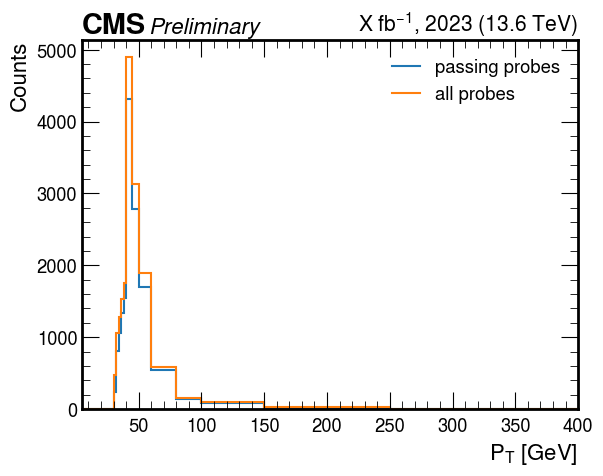

In [13]:
hpt_pass.plot1d(label="passing probes", flow="none")
hpt_all.plot1d(label="all probes", flow="none")
plt.xlim(5, 400)
plt.xlabel(r"$P_T$ [GeV]")
plt.ylabel(r"Counts")
plt.legend()
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.show()

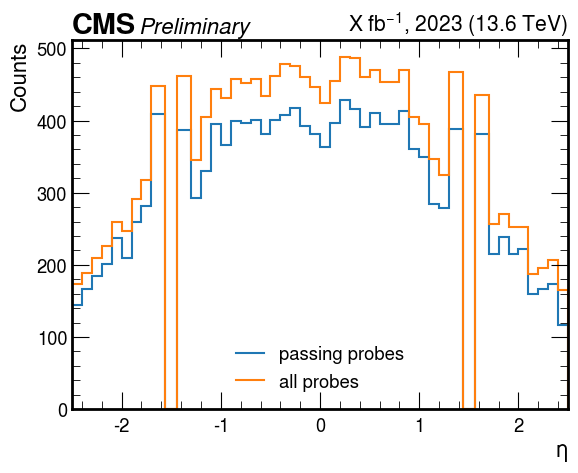

In [14]:
heta_pass.plot1d(label="passing probes", flow="none")
heta_all.plot1d(label="all probes", flow="none")
plt.xlim(-2.5, 2.5)
plt.xlabel(r"$\eta$")
plt.ylabel(r"Counts")
plt.legend()
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.show()

To get the efficiency plots, we will just use the `plot_efficiency` function that we imported earlier.

In [15]:
help(plot_efficiency)

Help on function plot_efficiency in module egamma_tnp.plot:

plot_efficiency(passing_probes, all_probes, **kwargs)
    Plot the efficiency using the ratio of passing probes to all probes.
    
    Parameters
    ----------
        passing_probes : hist.Hist
            The histogram of the passing probes.
        all_probes : hist.Hist
            The histogram of all probes.
        **kwargs
            Keyword arguments to pass to hist.Hist.plot1d.
    
    Returns
    -------
        List[Hist1DArtists]



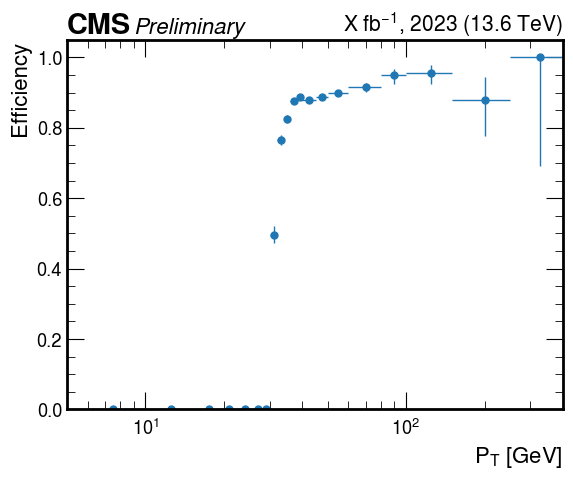

In [16]:
plot_efficiency(hpt_pass, hpt_all)
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.xlim(5, 400)
plt.xlabel(r"$P_T$ [GeV]")
plt.ylabel(r"Efficiency")
plt.xscale("log")
plt.show()

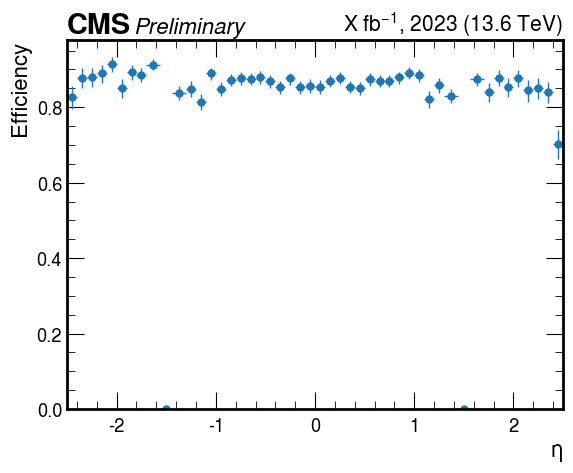

In [17]:
plot_efficiency(heta_pass, heta_all)
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.xlim(-2.5, 2.5)
plt.xlabel(r"$\eta$")
plt.ylabel(r"Efficiency")
plt.show()

Now that we've showcased the basic usage locally, let's move into a cluster. For the setup, please consult the README.

In [18]:
from distributed import Client

client = Client()

# or

# from distributed import Client
# from lpcjobqueue import LPCCondorCluster

# cluster = LPCCondorCluster(ship_env=True)
# cluster.adapt(minimum=1, maximum=100)
# client = Client(cluster)

# to use the condor farm on LPC

/Users/iason/fun/egamma_dev/venv/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61989 instead
  warnings.warn(


In [19]:
%%time

tag_n_probe = TagNProbe(
    [
        "/EGamma0/Run2023C-PromptNanoAODv12_v3-v1/NANOAOD",
        "/EGamma1/Run2023C-PromptNanoAODv12_v3-v1/NANOAOD",
    ],
    32,
    goldenjson="../json/Cert_Collisions2023_366442_368823_Golden.json",
    toquery=True,
    redirect=False,
)

tag_n_probe.load_events()
tag_n_probe

Loading SITECONF info


FileNotFoundError: [Errno 2] No such file or directory: '/cvmfs/cms.cern.ch/SITECONF/'

In [ ]:
%%time

(
    hpt_pass,
    hpt_all,
    heta_pass,
    heta_all,
) = tag_n_probe.get_tnp_histograms(compute=True, scheduler=None, progress=True)

print(f"Passing probes: {hpt_pass.sum(flow=True)}")
print(f"All probes: {hpt_all.sum(flow=True)}")

In [ ]:
hpt_pass.plot1d(label="passing probes", flow="none")
hpt_all.plot1d(label="all probes", flow="none")
plt.xlim(5, 400)
plt.xlabel(r"$P_T$ [GeV]")
plt.ylabel(r"Counts")
plt.legend()
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.show()

In [ ]:
heta_pass.plot1d(label="passing probes", flow="none")
heta_all.plot1d(label="all probes", flow="none")
plt.xlim(-2.5, 2.5)
plt.xlabel(r"$\eta$")
plt.ylabel(r"Counts")
plt.legend()
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.show()

In [ ]:
plot_efficiency(hpt_pass, hpt_all)
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.xlim(5, 400)
plt.xlabel(r"$P_T$ [GeV]")
plt.ylabel(r"Efficiency")
plt.xscale("log")
plt.show()

In [ ]:
plot_efficiency(heta_pass, heta_all)
hep.cms.label("Preliminary", data=True, lumi="X", year=2023, com=13.6)
plt.xlim(-2.5, 2.5)
plt.xlabel(r"$\eta$")
plt.ylabel(r"Efficiency")
plt.show()